In [199]:
import numpy as np
import sympy as sp
import IPython.display as disp

from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, transpile
import qiskit.circuit.library as qilib
import qiskit.quantum_info as qi
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram, plot_bloch_multivector
import sympy.physics.quantum as spQ


# Medidas

A medida projetiva na base computacinal corresponde a medição do estado quântico na base

$$
\{\ket{0}, \ket{1}\}
$$

para um qubit no estado

$$
\ket{\psi} = \alpha\ket{0} + \beta\ket{1}
$$

a medida projetiva colapsa o estado para

- $\ket{0}$ com probabilidade $|\alpha|^2$
- $\ket{1}$ com probabilidade $|\beta|^2$

No qiskit utilizamos o método `.measure()`.

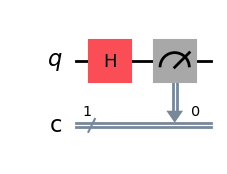

In [200]:
qc = QuantumCircuit(1, 1)

qc.h(0)

qc.measure(0, 0)

# Draw the circuit
qc.draw('mpl')

## Princípio da medida postergada

 Medidas podem ser sempre movidas de um estágio intermediário de um circuito quântico para o final do circuito. Se o resultado da medida é usado em qualquer estágio, então as operações controladas de forma clássica podem ser substituídas por operações condicionais quânticas.


Abaixo temos um exemplo com operações controladas por medidas de forma clássica e uma versão onde a medida é postergada.

**No circuito $qc_1$**:

1. Estado inicial
$$
    \ket{\psi} = \ket{q_1q_0} = \ket{00}
$$
2. Hadamard no qubit $0$
$$
H\ket{q_0} = \frac{1}{\sqrt{2}}(\ket{0}+\ket{1}) \implies \ket{\psi} = \frac{1}{\sqrt{2}}(\ket{00}+\ket{01})
$$
3. Medida em $q_0$
- 50% de chance de obtermos $\ket{00}$ e não aplicarmos o operador $X$.
- 50% de chance de obtermos $\ket{01}$ e aplicarmos o operador $X$ em $q_1$
$$
    X\otimes I\ket{01} = X\ket{0}\otimes I\ket{1} = \ket{11}.
$$
4. Portanto, $qc_1$ apresenta estado final $\ket{00}$ ou $\ket{11}$ com 50% de probabilidade cada.

**No circuito $qc_2$**:

1. Estado inicial
$$
    \ket{\psi} = \ket{q_1q_0} = \ket{00}
$$
2. Hadamard no qubit $0$
$$
H\ket{q_0} = \frac{1}{\sqrt{2}}(\ket{0}+\ket{1}) \implies \ket{\psi} = \frac{1}{\sqrt{2}}(\ket{00}+\ket{01})
$$
3. Aplica-se o operador CNOT com qubit de controle $q_0$ e qubit alvo $q_1$
$$
   CNOT\ket{q_1q_0} = \frac{1}{\sqrt{2}}(\ket{00}+\ket{11})
$$
4. Portanto, $qc_1$ apresenta estado final $\ket{00}$ ou $\ket{11}$ com 50% de probabilidade cada.

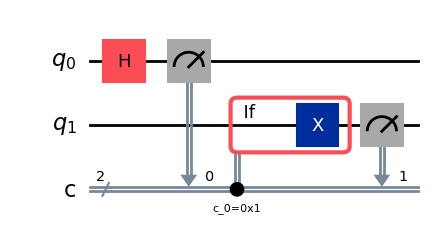

In [201]:
qr = QuantumRegister(2, "q")
cr = ClassicalRegister(2, "c")

qc1 = QuantumCircuit(qr, cr)

qc1.h(qr[0])

qc1.measure(qr[0], cr[0])

with qc1.if_test((cr[0], 1)):
    qc1.x(1)

qc1.measure(qr[1], cr[1])

qc1.draw('mpl')

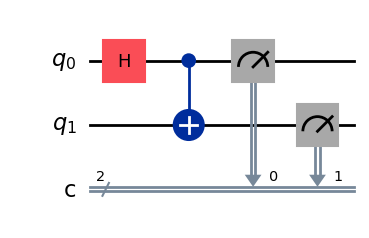

In [202]:
qc2 = QuantumCircuit(2, 2)

qc2.h(0)

qc2.cx(0, 1)

qc2.measure([0, 1], [0, 1])

qc2.draw('mpl')

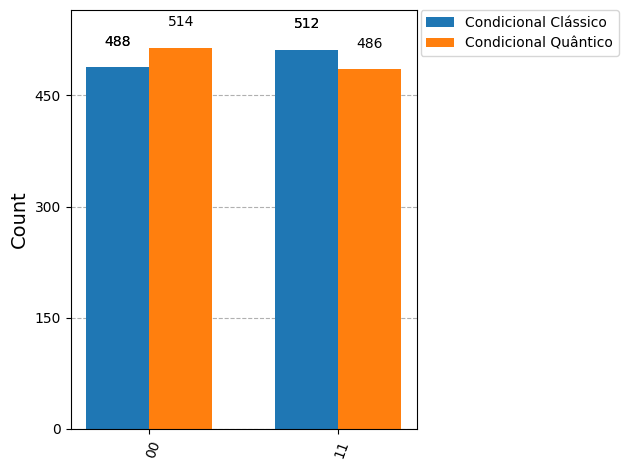

In [203]:
simulator = AerSimulator()

qc1 = transpile(qc1, simulator)
qc2 = transpile(qc2, simulator)

# Executar os dois circuitos
result1 = simulator.run(qc1, shots=1000).result().get_counts()
result2 = simulator.run(qc2, shots=1000).result().get_counts()

plot_histogram([result1, result2], legend=['Condicional Clássico', 'Condicional Quântico'])

### Teleporte Quântico

Relembrando, no teleporte quântico Alice e Bob compartilham um par EPR e Alice deseja enviar um qubit para Bob. Alice pode enviar apenas dois bits clássicos. Temos:

- $q_0$: O qubit que Alice deseja enviar para Bob, também chamado de $\ket{\psi}$.
- $q_1$: O qubit de Alice.
- $q_2$: o qubit de Bob.

os qubits $q_1$ e $q_2$ estão em um estado emaranhado

$$
\ket{q_1q_2} = \ket{\beta_{00}} = \frac{1}{\sqrt{2}}(\ket{00}+\ket{11})
$$

- $c_0$: o bit de resultado após Alice medir o estado $q_0$
- $c_0$: o bit de resultado após Alice medir o estado $q_1$

Existem quatro possibilidades:

1. $00$: Bob não precisa fazer nada, ou seja, $I\ket{q_0}$.
2. $01$: Bob aplica o operador $Z$, ou seja, $Z\ket{q_0}$.
3. $10$: Bob aplica o operador $X$, ou seja, $X\ket{q_0}$.
4. $11$: Bob aplica o operador $Z$ depois o operador $X$, ou seja, $XZ\ket{q_0}$.

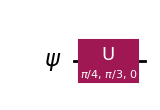

In [204]:
q = QuantumRegister(1, "ψ")
qcPsi = QuantumCircuit(q, name="U")

theta = np.pi/4
varphi = np.pi/3

qcPsi.u(theta, varphi, 0.0, 0)

qcPsi.draw("mpl")

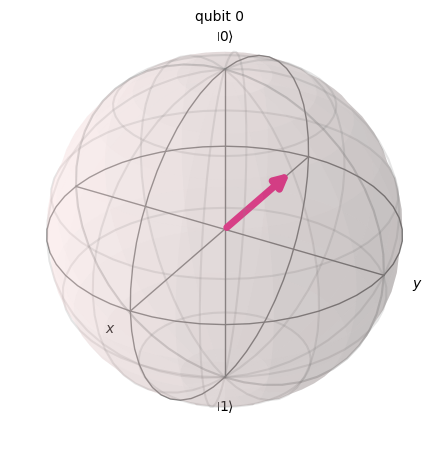

In [205]:
out_vector = qi.Statevector(qcPsi) 
plot_bloch_multivector(out_vector)

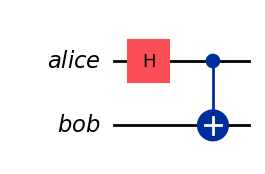

In [206]:
alice = QuantumRegister(1, "alice")
bob = QuantumRegister(1, "bob")

qcBell = QuantumCircuit(alice, bob, name="β00")

# Criação do par EPR entre q1 e q2
qcBell.h(0)
qcBell.cx(0, 1)

qcBell.draw("mpl")

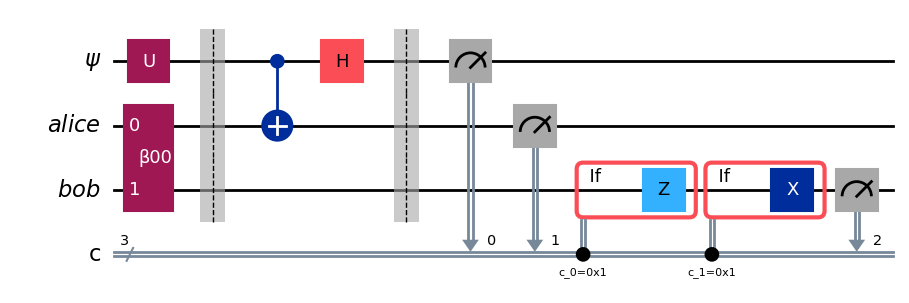

In [207]:
q = QuantumRegister(1, "ψ")

cr = ClassicalRegister(3, "c")
qc1 = QuantumCircuit(q, alice, bob, cr)

qc1.append(qcPsi, [0])
qc1.append(qcBell, [1,2])

qc1.barrier()

qc1.cx(0, 1)
qc1.h(0)

qc1.barrier()

# Medição intermediária
qc1.measure(0, 0)
qc1.measure(1, 1)

with qc1.if_test((cr[0], 1)):
    qc1.z(bob)

with qc1.if_test((cr[1], 1)):
    qc1.x(bob)

qc1.measure(2, 2)

qc1.draw('mpl')

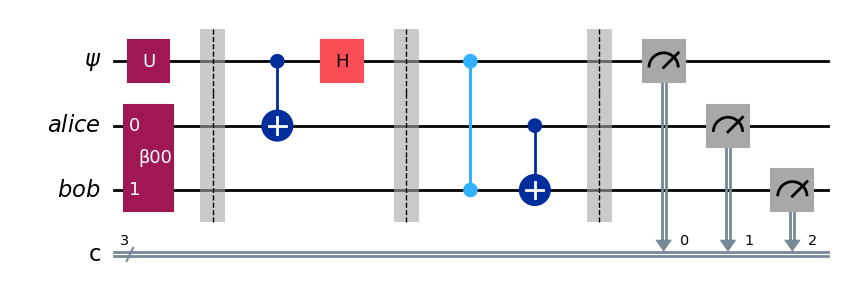

In [208]:
q = QuantumRegister(1, "ψ")
alice = QuantumRegister(1, "alice")
bob = QuantumRegister(1, "bob")

cr = ClassicalRegister(3, "c")
qc2 = QuantumCircuit(q, alice, bob, cr)

qc2.append(qcPsi, [0])
qc2.append(qcBell, [1,2])

qc2.barrier()

qc2.cx(0, 1)
qc2.h(0)

qc2.barrier()

qc2.cz(0, 2)
qc2.cx(1, 2)

qc2.barrier()

qc2.measure([0, 1, 2], [0, 1, 2])

qc2.draw("mpl")

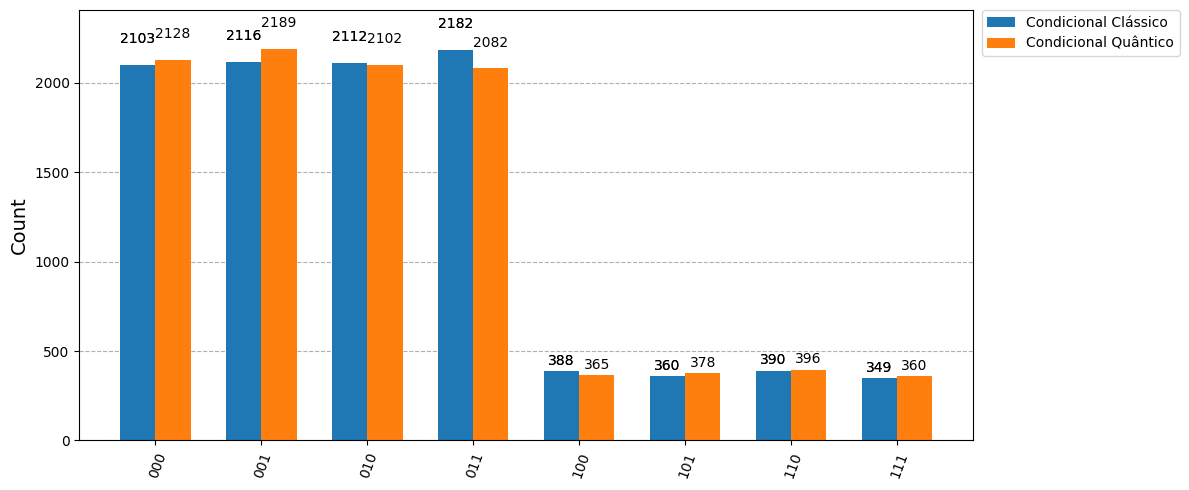

In [209]:
simulator = AerSimulator()

qc1 = transpile(qc1, simulator)
qc2 = transpile(qc2, simulator)

# Executar os dois circuitos
result1 = simulator.run(qc1, shots=10000).result().get_counts()
result2 = simulator.run(qc2, shots=10000).result().get_counts()

plot_histogram([result1, result2], legend=['Condicional Clássico', 'Condicional Quântico'], figsize=(12, 5))

## Princípio da medida implícita

Sem perda de generalidade qualquer "fio quântico" (que não tenha sido medido) ao final do circuito quântico, pode ser assumido como medido.

Considere $\rho$ a matriz de densidade de um sistema de dois qubits e suponha que seja feita medida projetiva na base computacional para o segundo qubit. Sendo $P_0 = \ket{0}\bra{0}$ e $P_1= \ket{1}\bra{1}$ as projeções para os estados $\ket{0}$ e $\ket{1}$ do segundo qubit, respectivamente. Se $\rho'$ é a matriz de densidade associada ao sistema após medição por um observador que não sabe o resultado da medida então

$$
\rho' = P_0\rho P_0 + P_1\rho P_1
$$

In [210]:
def partial_trace_2qubits(ρ, keep):
    if keep == '0':
        return sp.Matrix([
            [ρ[0, 0] + ρ[1, 1], ρ[0, 2] + ρ[1, 3]],
            [ρ[2, 0] + ρ[3, 1], ρ[2, 2] + ρ[3, 3]]
        ])
    elif keep == '1':
        return sp.Matrix([
            [ρ[0, 0] + ρ[2, 2], ρ[0, 1] + ρ[2, 3]],
            [ρ[1, 0] + ρ[3, 2], ρ[1, 1] + ρ[3, 3]]
        ])
    else:
        raise ValueError("keep must be '0' or '1'")


α1, β1, α2, β2 = sp.symbols('alpha_1 beta_1 alpha_2 beta_2', complex=True)

ket_s1 = sp.Matrix([α1, β1])
ket_s2 = sp.Matrix([α2, β2])

ket_psi = spQ.TensorProduct(ket_s1, ket_s2)

disp.display(disp.Math(r"\ket{s_1} = " 
    + sp.latex(ket_s1)
    + r", \ket{s_2} = " + sp.latex(ket_s2)
    + r"\implies \ket{\psi}=\ket{s_1}\otimes\ket{s_2}=" + sp.latex(ket_psi)
))

ρ = ket_psi * ket_psi.H
ρ_1_reduced = partial_trace_2qubits(ρ, '0')

disp.display(disp.Math(r"\rho=\ket{\psi}\bra{\psi}="
    + sp.latex(ρ)
    + r"\implies "r"\rho^1=\operatorname{tr}_2(\ket{s_1}\bra{s_1}\otimes\ket{s_2}\bra{s_2})=" + sp.latex(ρ_1_reduced)))

I2 = sp.eye(2)

P0 = spQ.TensorProduct(I2, sp.Matrix([
    [1, 0],
    [0, 0],
]))

P1 = spQ.TensorProduct(I2, sp.Matrix([
    [0, 0],
    [0, 1],
]))

disp.display(disp.Math(r"P_0=" + sp.latex(P0)+ r", P_1="+sp.latex(P1)))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

O estado após a medida é dado por:
$$
\rho' = \frac{M_m\rho M_m^\dagger}{\operatorname{tr}(M_m^\dagger M_m \rho)}
$$

Como o observador não sabe o resultado da medida temos:

$$
\begin{align*}
\rho' &= \sum_m p(m)\rho_m \\
     &= \sum_m \operatorname{tr}(P^\dagger_m P_m \rho) \frac{M_m\rho M^\dagger_m}{\operatorname{tr}(P^\dagger_m P_m \rho)} \\
     &= \sum_m P_m\rho P^\dagger_m = \sum_m P_m\rho P_m = P_0\rho P_0 + P_1\rho P_1.
\end{align*}
$$

Além disso,


In [211]:
ρ_prime = P0*ρ*P0 + P1*ρ*P1
disp.display(disp.Math(r"\rho'=" + sp.latex(ρ_prime)))

ρ_1 = partial_trace_2qubits(ρ_prime, '0')
ρ_prime_1 = partial_trace_2qubits(ρ_prime, '0')

disp.display(disp.Math(r"\rho^1=" + sp.latex(ρ_1)))
disp.display(disp.Math(r"(\rho')^1=" + sp.latex(ρ_prime_1)))

print(ρ_prime_1.equals(ρ_1))


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

True


Como exemplo, para $\ket{\psi} = \frac{1}{\sqrt{2}}(\ket{00}+\ket{11})$ temos:

In [212]:
qc = QuantumCircuit(2)

#  produz |ψ> = (|00> + |11>)/sqrt(2)
qc.h(0)
qc.cx(0, 1)

psi = qi.Statevector(qc)
rho = qi.DensityMatrix(psi)

# Projetores no segundo qubit: |0><0| e |1><1|
P0 = qi.DensityMatrix.from_label('0')
P1 = qi.DensityMatrix.from_label('1')

# Operadores de projeção no sistema de dois qubits: I ⊗ P0 e I ⊗ P1
P0_op = np.kron(np.eye(2), P0.data)
P1_op = np.kron(np.eye(2), P1.data)

# Aplicar: ρ' = P0 ρ P0 + P1 ρ P1
rho_prime_data = P0_op @ rho.data @ P0_op + P1_op @ rho.data @ P1_op
rho_prime = qi.DensityMatrix(rho_prime_data)

# Calcular traços parciais sobre o segundo qubit
rho_0_reduced = qi.partial_trace(rho, [1])
rho_prime_0_reduced = qi.partial_trace(rho_prime, [1])

disp.display(disp.Math(r"\operatorname{tr_2}(ρ) == \operatorname{tr_2}(ρ'): " + str(rho_0_reduced == rho_prime_0_reduced)))

disp.display(disp.Math(r"\rho^1=(\rho')^1=" + sp.latex(sp.Matrix(rho_0_reduced))))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Abaixo, construímos circuitos que produzem os estados de Bell e, em seguida, mostramos um circuito que a medida na base computacional corresponde a medida na base de Bell.

In [213]:
qc_bell_00 = QuantumCircuit(2, 2, name="β00")

qc_bell_00.h(0)
qc_bell_00.cx(0, 1)

qc_bell_00.draw()

┌───┐     
q_0: ┤ H ├──■──
     └───┘┌─┴─┐
q_1: ─────┤ X ├
          └───┘
c: 2/══════════

In [214]:
qc_bell_01 = QuantumCircuit(2, 2, name="β01")

qc_bell_01.x(0)
qc_bell_01.h(1)
qc_bell_01.cx(1, 0)

# qc_bell_01.draw()

# Simulate using AerSimulator
simulator = AerSimulator(method='statevector')
qc_bell_01.save_statevector()
qc_bell_01 = transpile(qc_bell_01, simulator)
result = simulator.run(qc_bell_01).result()
state = result.get_statevector()

print(state)


Statevector([0.        +0.j, 0.70710678+0.j, 0.70710678+0.j,
             0.        +0.j],
            dims=(2, 2))


In [215]:
qc_bell_10 = QuantumCircuit(2, 2, name="β10")

qc_bell_10.h(0)
qc_bell_10.cx(0, 1)
qc_bell_10.z(0)

qc_bell_10.draw()

┌───┐     ┌───┐
q_0: ┤ H ├──■──┤ Z ├
     └───┘┌─┴─┐└───┘
q_1: ─────┤ X ├─────
          └───┘     
c: 2/═══════════════

In [216]:
qc_bell_11 = QuantumCircuit(2, 2, name="β11")

qc_bell_11.x(0)
qc_bell_11.h(1)
qc_bell_11.cx(1, 0)
qc_bell_11.z(1)

qc_bell_11.draw()

┌───┐┌───┐     
q_0: ┤ X ├┤ X ├─────
     ├───┤└─┬─┘┌───┐
q_1: ┤ H ├──■──┤ Z ├
     └───┘     └───┘
c: 2/═══════════════

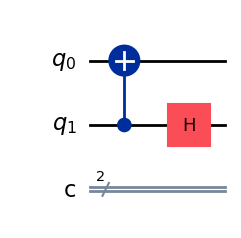

In [217]:
qc_bell_measurement = QuantumCircuit(2, 2, name="U")

qc_bell_measurement.cx(1, 0)
qc_bell_measurement.h(1)

qc_bell_measurement.draw("mpl")

/home/marcio/repositories/personal/qc-examples/venv/lib/python3.12/site-packages/qiskit/circuit/quantumcircuit.py:3808: RuntimeWarning: Cregbundle set to False since an instruction needs to refer to individual classical wire
  return circuit_drawer(


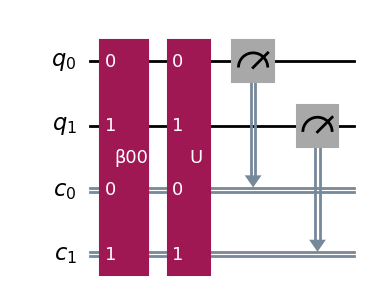

In [218]:
qc_bell_00_measurement = QuantumCircuit(2, 2)
qc_bell_00_measurement.append(qc_bell_00, [0, 1], [0, 1])
qc_bell_00_measurement.append(qc_bell_measurement, [0, 1], [0, 1])
qc_bell_00_measurement.measure([0, 1], [0, 1])

qc_bell_00_measurement.draw('mpl')

In [219]:
qc_bell_01_measurement = QuantumCircuit(2, 2)
qc_bell_01_measurement.append(qc_bell_01, [0, 1], [0, 1])
qc_bell_01_measurement.append(qc_bell_measurement, [0, 1], [0, 1])
qc_bell_01_measurement.measure([0, 1], [0, 1])

qc_bell_10_measurement = QuantumCircuit(2, 2)
qc_bell_10_measurement.append(qc_bell_10, [0, 1], [0, 1])
qc_bell_10_measurement.append(qc_bell_measurement, [0, 1], [0, 1])
qc_bell_10_measurement.measure([0, 1], [0, 1])

qc_bell_11_measurement = QuantumCircuit(2, 2)
qc_bell_11_measurement.append(qc_bell_11, [0, 1], [0, 1])
qc_bell_11_measurement.append(qc_bell_measurement, [0, 1], [0, 1])
qc_bell_11_measurement.measure([0, 1], [0, 1])

qcircs = {
    'β00': qc_bell_00_measurement,
    'β01': qc_bell_01_measurement,
    'β10': qc_bell_10_measurement,
    'β11': qc_bell_11_measurement,
}

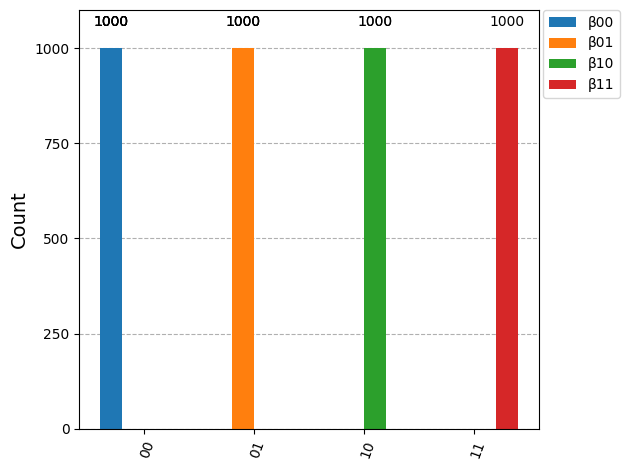

In [223]:
labels = []
results = []
for label, circ in qcircs.items():
    sim = AerSimulator()
    circ = transpile(circ, sim)
    labels.append(label)
    result = sim.run(circ, shots=1000).result().get_counts()
    results.append(result)

plot_histogram(results, legend=labels)

Do gráfico acima, ao medir na base computacional cada um dos estados de Bell
$$
\{\beta_{00}, \beta_{01}, \beta_{10}, \beta_{11}\}
$$
obtemos 100\% de chance de obtermos "$xx$" ao medir o estado $\beta_{xx}$. Equivalentemente, podemos medir com operadores da base de Bell, confirme código abaixo

In [221]:
# Define computational basis
ket00 = sp.Matrix([[1], [0], [0], [0]])
ket01 = sp.Matrix([[0], [1], [0], [0]])
ket10 = sp.Matrix([[0], [0], [1], [0]])
ket11 = sp.Matrix([[0], [0], [0], [1]])

norm = 1/sp.sqrt(2)

# Bell states
beta00 = norm * (ket00 + ket11)
beta01 = norm * (ket01 + ket10)
beta10 = norm * (ket00 - ket11)
beta11 = norm * (ket01 - ket10)

P00 = beta00 * beta00.H
P01 = beta01 * beta01.H
P10 = beta10 * beta10.H
P11 = beta11 * beta11.H

operators = {
    "00": P00,
    "01": P01,
    "10": P10,
    "11": P11,
}

states = {
    "00": beta00,
    "01": beta01,
    "10": beta10,
    "11": beta11,
}

for label, state in states.items():
    for label_p, op in operators.items():
        if label is not label_p:
            continue
        disp.display(disp.Math(r"p(\beta_{"+label_p+r"}) = \braket{"+label+r"|P_{\beta_{"+ label_p + r"}}|"+label+r"}="+ sp.latex(state.dot(op * state))))



<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>